Here’s a `qiskit` implementation for finding the ground state of a spin glass model with a randomly generated interaction graph. This example uses the **Quantum Approximate Optimization Algorithm (QAOA)** to solve the combinatorial optimization problem encoded in the spin glass Hamiltonian.

In [1]:
import qiskit
print(qiskit.version.get_version_info())

C:\Users\slipo\anaconda3\envs\old_qiskit\lib\site-packages\qiskit\circuit\equivalence.py:18: DeprecationWarning: The retworkx package is deprecated and has been renamed to rustworkx. Rustworkx is a drop-in replacement and can be used by replacing `import retworkx` with import `rustworkx`. 
  import retworkx as rx
C:\Users\slipo\anaconda3\envs\old_qiskit\lib\site-packages\qiskit\version.py:20: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


0.18.1


### **Step 1: Define the Interaction Graph**
We’ll generate a random weighted graph using `networkx` to represent the spin glass interactions. Each node is a spin, and edges represent couplings between spins (weights = interaction strengths).

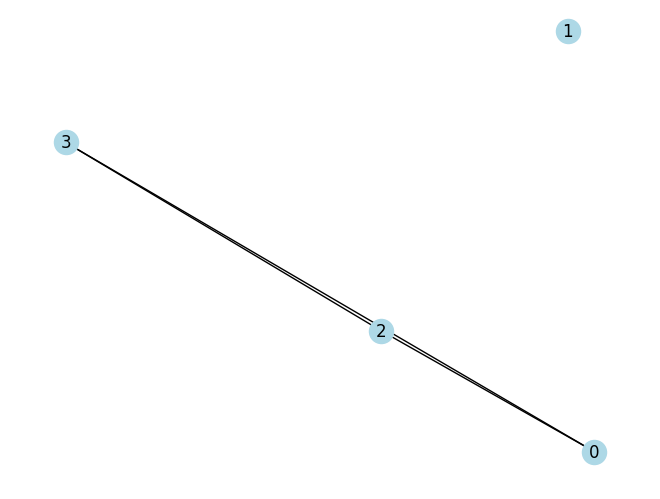

In [2]:
import numpy as np
import networkx as nx
from qiskit import Aer
from qiskit.algorithms import QAOA
from qiskit.algorithms.optimizers import COBYLA
from qiskit.opflow import PauliSumOp
from qiskit.utils import QuantumInstance
from qiskit.visualization import plot_histogram

# Step 1: Define a random interaction graph
num_qubits = 4  # Small system for demonstration
graph = nx.Graph()
graph.add_nodes_from(range(num_qubits))

# Add random edges with weights (representing spin couplings)
np.random.seed(42)
for i in range(num_qubits):
    for j in range(i + 1, num_qubits):
        if np.random.random() > 0.5:  # Random connectivity
            J_ij = np.random.uniform(-1, 1)  # Random coupling strength
            graph.add_edge(i, j, weight=J_ij)

# Visualize the graph
nx.draw(graph, with_labels=True, node_color='lightblue')

### **Step 2: Encode the Spin Glass Hamiltonian**
The Hamiltonian for the spin glass can be written in terms of Pauli-\(Z\) operators:
$$
H = \sum_{(i,j) \in E} J_{ij} Z_i Z_j
$$
where \(J_{ij}\) is the interaction strength between spins \(i\) and \(j\).

In [3]:
# Step 2: Convert graph to Ising Hamiltonian
def graph_to_hamiltonian(graph):
    num_qubits = graph.number_of_nodes()
    pauli_terms = []
    for i, j in graph.edges():
        J_ij = graph[i][j]['weight']
        pauli_str = ['I'] * num_qubits
        pauli_str[i] = 'Z'
        pauli_str[j] = 'Z'
        pauli_str = ''.join(pauli_str)
        pauli_term = PauliSumOp.from_list([(pauli_str, J_ij)])
        pauli_terms.append(pauli_term)
    hamiltonian = sum(pauli_terms).reduce()
    return hamiltonian

hamiltonian = graph_to_hamiltonian(graph)
print("Hamiltonian:\n", hamiltonian)

Hamiltonian:
 0.4639878836228102 * ZIZI
- 0.687962719115127 * ZIIZ
+ 0.2022300234864176 * IIZZ


### **Step 3: Configure and Run QAOA**
QAOA will search for the ground state by minimizing the expectation value of the Hamiltonian.

In [4]:
# Step 3: Configure QAOA
optimizer = COBYLA(maxiter=100)
backend = Aer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024)
qaoa = QAOA(optimizer=optimizer, reps=2, quantum_instance=quantum_instance)  # reps = number of QAOA layers
backend = Aer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024)

# Run QAOA
result = qaoa.compute_minimum_eigenvalue(hamiltonian)
print("Optimal parameters:", result.optimal_parameters)

Optimal parameters: {ParameterVectorElement(t[0]): np.float64(-2.196669243927314), ParameterVectorElement(t[1]): np.float64(-5.321256187009046), ParameterVectorElement(t[2]): np.float64(-2.1265355243851536), ParameterVectorElement(t[3]): np.float64(-4.960638035130566)}


### **Step 4: Analyze Results**
Extract the most probable bitstring (spin configuration) from the QAOA result and verify it against the classical ground state.

In [42]:
# Step 4: Get the ground state configuration from QAOA
counts = result.eigenstate
if counts is not None:
    tot_prob = np.sum([counts[key]*np.conj(counts[key]) for key in counts])
    max_prob = np.max([counts[key]*np.conj(counts[key]) for key in counts])
    print("Total prob:",tot_prob)
    print("Max prob:",max_prob)
    for key in counts:
        if counts[key]*np.conj(counts[key]) == max_prob:
            print(counts[key],key[::-1])
            ground_state=key[::-1]
    print("QAOA ground state (bitstring):", ground_state)
else:
    print("No result from QAOA.")

Total prob: 1.0
Max prob: 0.189453125
0.4352621336620037 0100
0.4352621336620037 0110
QAOA ground state (bitstring): 0110


In [15]:
counts

{'0000': np.float64(0.11267347735824966),
 '0001': np.float64(0.11267347735824966),
 '0010': np.float64(0.4352621336620037),
 '0011': np.float64(0.21194781197266463),
 '0100': np.float64(0.13258252147247765),
 '0101': np.float64(0.09375),
 '0110': np.float64(0.4352621336620037),
 '0111': np.float64(0.17399263633843817),
 '1000': np.float64(0.22534695471649932),
 '1001': np.float64(0.4192627457812106),
 '1010': np.float64(0.11692679333668567),
 '1011': np.float64(0.11692679333668567),
 '1100': np.float64(0.1795175827043134),
 '1101': np.float64(0.40745015032516557),
 '1110': np.float64(0.12103072956898178),
 '1111': np.float64(0.16535945694153692)}

In [16]:
result.eigenvalue

np.complex128(-0.8682095096740517+0j)

In [44]:
# Step 5: Verify with classical brute-force calculation
def classical_ground_state(graph, num_qubits):
    min_energy = np.inf
    best_config = None
    # Iterate over all possible spin configurations (2^num_qubits)
    for config in range(2**num_qubits):
        binary = bin(config)[2:].zfill(num_qubits)
        energy = 0
        for i, j in graph.edges():
            J_ij = graph[i][j]['weight']
            s_i = (-1)**int(binary[-i-1])  # Convert bit to spin (+1/-1)
            s_j = (-1)**int(binary[-j-1])
            energy += J_ij * s_i * s_j
        print("energy:",energy,"config:",binary)
        if energy < min_energy:
            min_energy = energy
            best_config = binary
    return best_config, min_energy

classical_config, classical_energy = classical_ground_state(graph, num_qubits)
print("\nClassical ground state (bitstring):", classical_config)

energy: -0.021744812005899172 config: 0000
energy: 0.4262048589787344 config: 0001
energy: -0.021744812005899172 config: 0010
energy: 0.4262048589787344 config: 0011
energy: -1.3541806262243548 config: 0100
energy: 0.9497205792515195 config: 0101
energy: -1.3541806262243548 config: 0110
energy: 0.9497205792515195 config: 0111
energy: 0.9497205792515195 config: 1000
energy: -1.3541806262243548 config: 1001
energy: 0.9497205792515195 config: 1010
energy: -1.3541806262243548 config: 1011
energy: 0.4262048589787344 config: 1100
energy: -0.021744812005899172 config: 1101
energy: 0.4262048589787344 config: 1110
energy: -0.021744812005899172 config: 1111

Classical ground state (bitstring): 0100


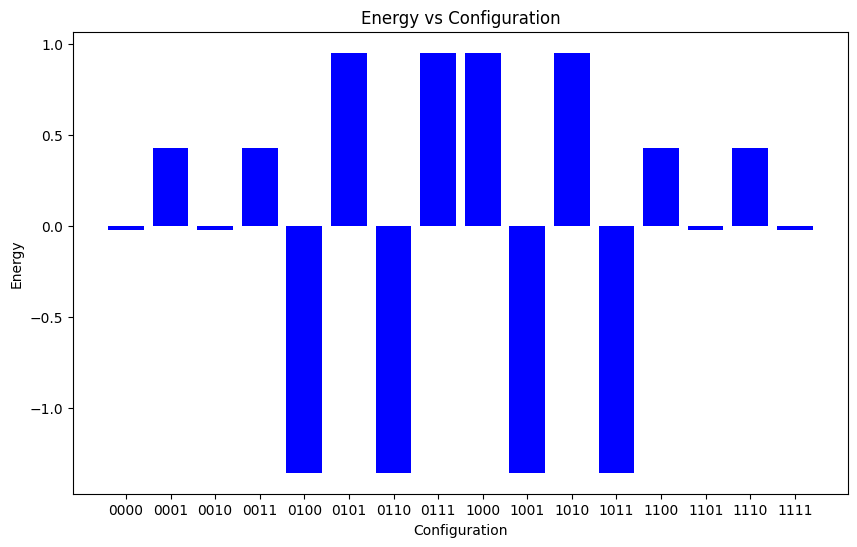

In [1]:
import matplotlib.pyplot as plt

# Data
configs = ['0000', '0001', '0010', '0011', '0100', '0101', '0110', '0111', '1000', '1001', '1010', '1011', '1100', '1101', '1110', '1111']
energies = [-0.021744812005899172, 0.4262048589787344, -0.021744812005899172, 0.4262048589787344, -1.3541806262243548, 0.9497205792515195, -1.3541806262243548, 0.9497205792515195, 0.9497205792515195, -1.3541806262243548, 0.9497205792515195, -1.3541806262243548, 0.4262048589787344, -0.021744812005899172, 0.4262048589787344, -0.021744812005899172]

# Create bar graph
plt.figure(figsize=(10, 6))
plt.bar(configs, energies, color='blue')

# Add labels and title
plt.xlabel('Configuration')
plt.ylabel('Energy')
plt.title('Energy vs Configuration')

# Show plot
plt.show()

# Final Code

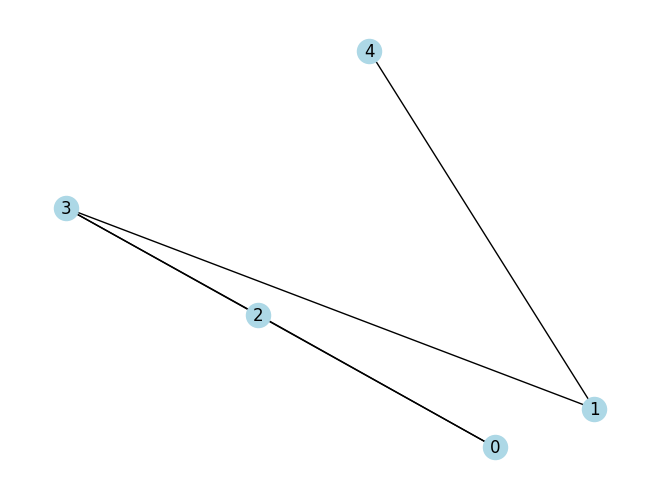

In [2]:
import numpy as np
import networkx as nx
from qiskit import Aer
from qiskit.algorithms import QAOA
from qiskit.algorithms.optimizers import COBYLA
from qiskit.opflow import PauliSumOp
from qiskit.utils import QuantumInstance
from qiskit.visualization import plot_histogram

def create_random_graph(n):
    # Step 1: Define a random interaction graph
    num_qubits = n  # Small system for demonstration
    graph = nx.Graph()
    graph.add_nodes_from(range(num_qubits))

    # Add random edges with weights (representing spin couplings)
    np.random.seed(42)
    for i in range(num_qubits):
        for j in range(i + 1, num_qubits):
            if np.random.random() > 0.5:  # Random connectivity
                J_ij = np.random.uniform(-1, 1)  # Random coupling strength
                graph.add_edge(i, j, weight=J_ij)

    # Visualize the graph
    nx.draw(graph, with_labels=True, node_color='lightblue')
    return (graph, num_qubits)

graph,  num_qubits = create_random_graph(5)

In [3]:
# Step 2: Convert graph to Ising Hamiltonian
def graph_to_hamiltonian(graph):
    num_qubits = graph.number_of_nodes()
    pauli_terms = []
    for i, j in graph.edges():
        J_ij = graph[i][j]['weight']
        pauli_str = ['I'] * num_qubits
        pauli_str[i] = 'Z'
        pauli_str[j] = 'Z'
        pauli_str = ''.join(pauli_str)
        pauli_term = PauliSumOp.from_list([(pauli_str, J_ij)])
        pauli_terms.append(pauli_term)
    hamiltonian = sum(pauli_terms).reduce()
    return hamiltonian

hamiltonian = graph_to_hamiltonian(graph)
print("Hamiltonian:\n", hamiltonian)

# Step 3: Configure QAOA
optimizer = COBYLA(maxiter=100)
backend = Aer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=2048)
qaoa = QAOA(optimizer=optimizer, reps=3, quantum_instance=quantum_instance)  # reps = number of QAOA layers
backend = Aer.get_backend('qasm_simulator')
#quantum_instance = QuantumInstance(backend, shots=1024)

# Run QAOA
result = qaoa.compute_minimum_eigenvalue(hamiltonian)
print("\n\nOptimal parameters:", result.optimal_parameters)

# Step 4: Get the ground state configuration from QAOA
counts = result.eigenstate
if counts is not None:
    tot_prob = np.sum([counts[key]*np.conj(counts[key]) for key in counts])
    max_prob = np.max([counts[key]*np.conj(counts[key]) for key in counts])
    print("Total prob:",tot_prob)
    print("Max prob:",max_prob)
    for key in counts:
        if counts[key]*np.conj(counts[key]) == max_prob:
            print(counts[key],key[::-1])
            ground_state=key[::-1]
    print("\nQAOA ground state (bitstring):", ground_state,"\n")
else:
    print("\nNo result from QAOA.\n")

# Step 5: Verify with classical brute-force calculation
classical_config_list = []
classical_energy_list = []
def classical_ground_state(graph, num_qubits):
    min_energy = np.inf
    best_config = None
    # Iterate over all possible spin configurations (2^num_qubits)
    for config in range(2**num_qubits):
        binary = bin(config)[2:].zfill(num_qubits)
        energy = 0
        for i, j in graph.edges():
            J_ij = graph[i][j]['weight']
            s_i = (-1)**int(binary[-i-1])  # Convert bit to spin (+1/-1)
            s_j = (-1)**int(binary[-j-1])
            energy += J_ij * s_i * s_j
        print("energy:",energy,"config:",binary)
        classical_config_list.append(binary)
        classical_energy_list.append(energy)
        if energy < min_energy:
            min_energy = energy
            best_config = binary
    return best_config, min_energy

classical_config, classical_energy = classical_ground_state(graph, num_qubits)
print("\nClassical ground state (bitstring):", classical_config)
print("\nClassical ground state energy:", classical_energy)

Hamiltonian:
 0.4639878836228102 * ZIZII
- 0.687962719115127 * ZIIZI
+ 0.2022300234864176 * IZIZI
+ 0.6648852816008435 * IIZZI
- 0.9588310114083951 * IZIIZ


Optimal parameters: {ParameterVectorElement(t[0]): -1.9112089006780544, ParameterVectorElement(t[1]): 6.131581857649886, ParameterVectorElement(t[2]): 3.831957089507385, ParameterVectorElement(t[3]): -2.5101629340708937, ParameterVectorElement(t[4]): 1.1925148993870538, ParameterVectorElement(t[5]): 3.5448402389776277}
Total prob: 1.0
Max prob: 0.19824218749999997
0.44524396402421895 10110

QAOA ground state (bitstring): 10110 

energy: -0.3156905418134508 config: 00000
energy: 0.13225912917118277 config: 00001
energy: 1.1975114340305042 config: 00010
energy: 1.6454611050151378 config: 00011
energy: -2.573436872260758 config: 00100
energy: -0.26953566678488383 config: 00101
energy: -1.0602348964168031 config: 00110
energy: 1.2436663090590712 config: 00111
energy: -0.673995713757719 config: 01000
energy: -2.977896919233593 config: 

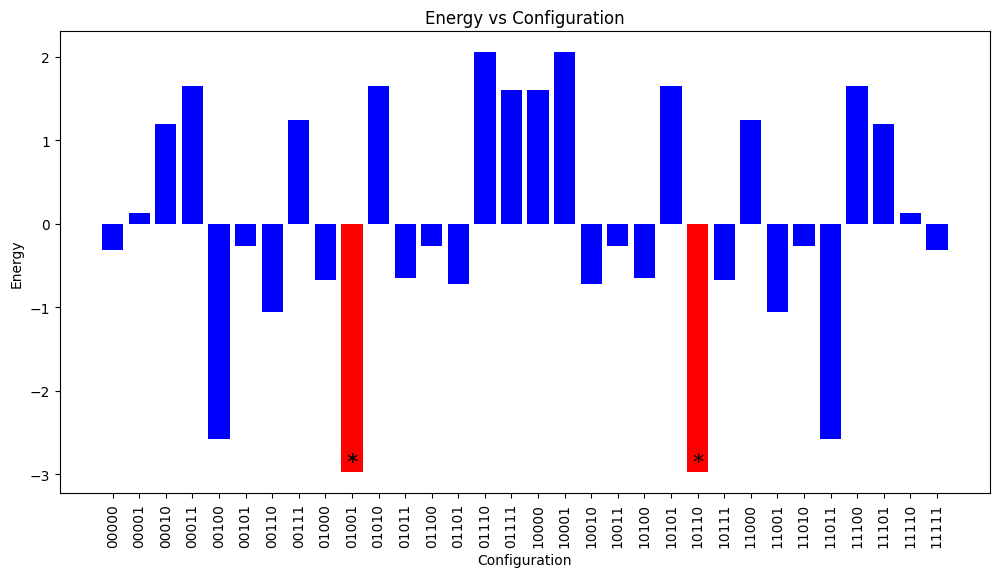

In [4]:
import matplotlib.pyplot as plt

def plot_configs_energy(configs, energies):
    # Create bar graph
    plt.figure(figsize=(12, 6))
    bars = plt.bar(configs, energies, color=['red' if config == classical_config else 'blue' for config in configs])
    bars2 = plt.bar(configs, energies, color=['red' if energy == classical_energy else 'blue' for energy in energies])

    # Add labels and title
    plt.xlabel('Configuration')
    plt.ylabel('Energy')
    plt.title('Energy vs Configuration')
    # Rotate x-axis labels upside down
    plt.xticks(rotation=90, ha='center', va='top')

     # Highlight lowest eneryg config with a marker
    for bar, config in zip(bars, configs):
        if config == classical_config:
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), '*', ha='center', va='bottom', fontsize=16, color='black')

    for bar, energy in zip(bars2, energies):
        if energy == classical_energy:
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), '*', ha='center', va='bottom', fontsize=16, color='black')

    # Show plot
    plt.show()

plot_configs_energy(classical_config_list, classical_energy_list)

- collect all together for convenience...

In [7]:
def run_all(n):
    # Step 1: Define a random interaction graph
    graph, num_qubits = create_random_graph(n)
    
    # Step 2: Convert graph to Ising Hamiltonian
    hamiltonian = graph_to_hamiltonian(graph)
    print("Hamiltonian:\n", hamiltonian)
    
    # Step 3: Configure QAOA
    optimizer = COBYLA(maxiter=100)
    backend = Aer.get_backend('qasm_simulator')
    quantum_instance = QuantumInstance(backend, shots=2048)
    qaoa = QAOA(optimizer=optimizer, reps=4, quantum_instance=quantum_instance)  # reps = number of QAOA layers
    backend = Aer.get_backend('qasm_simulator')


    # Run QAOA
    result = qaoa.compute_minimum_eigenvalue(hamiltonian)
    print("\n\nOptimal parameters:", result.optimal_parameters)

    # Step 4: Get the ground state configuration from QAOA
    counts = result.eigenstate
    if counts is not None:
        tot_prob = np.sum([counts[key]*np.conj(counts[key]) for key in counts])
        max_prob = np.max([counts[key]*np.conj(counts[key]) for key in counts])
        print("Total prob:",tot_prob)
        print("Max prob:",max_prob)
        for key in counts:
            if counts[key]*np.conj(counts[key]) == max_prob:
                print(counts[key],key[::-1])
                ground_state=key[::-1]
        print("\nQAOA ground state (bitstring):", ground_state,"\n")
    else:
        print("\nNo result from QAOA.\n")

    # Step 5: Verify with classical brute-force calculation
    classical_config, classical_energy = classical_ground_state(graph, num_qubits)
    print("\nClassical ground state (bitstring):", classical_config)
    print("\nClassical ground state energy:", classical_energy)
    return classical_config, classical_energy

# Example 1 (5 qubits)

Hamiltonian:
 0.4639878836228102 * ZIZII
- 0.687962719115127 * ZIIZI
+ 0.2022300234864176 * IZIZI
+ 0.6648852816008435 * IIZZI
- 0.9588310114083951 * IZIIZ


Optimal parameters: {ParameterVectorElement(t[0]): 2.4807166952128363, ParameterVectorElement(t[1]): 0.9409822186336624, ParameterVectorElement(t[2]): 0.0735347525456889, ParameterVectorElement(t[3]): 2.4824955696624023, ParameterVectorElement(t[4]): 6.08746563600168, ParameterVectorElement(t[5]): 4.156683186190354, ParameterVectorElement(t[6]): 2.322744925192706, ParameterVectorElement(t[7]): 6.193063175546897}
Total prob: 1.0
Max prob: 0.22119140624999997
0.47030990447788784 01001

QAOA ground state (bitstring): 01001 

energy: -0.3156905418134508 config: 00000
energy: 0.13225912917118277 config: 00001
energy: 1.1975114340305042 config: 00010
energy: 1.6454611050151378 config: 00011
energy: -2.573436872260758 config: 00100
energy: -0.26953566678488383 config: 00101
energy: -1.0602348964168031 config: 00110
energy: 1.243666309059

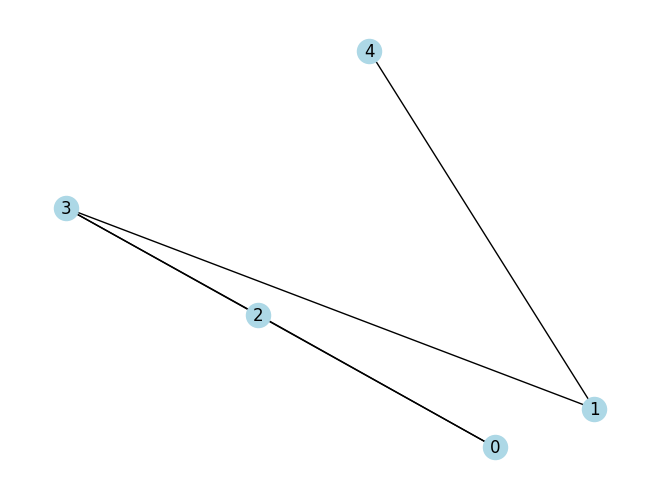

In [8]:
classical_config_list = []
classical_energy_list = []
classical_config, classical_energy = run_all(5)

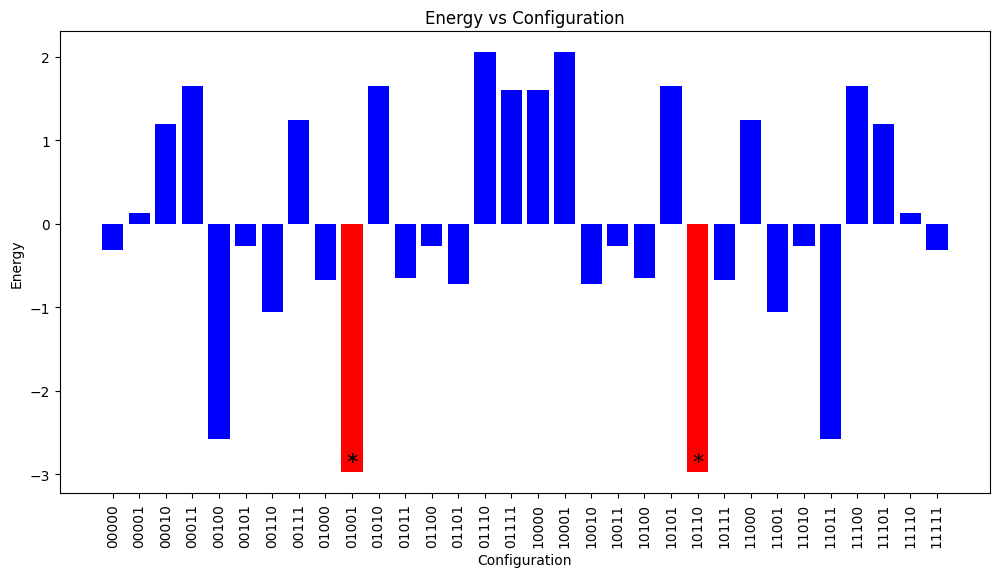

In [9]:
plot_configs_energy(classical_config_list, classical_energy_list)

In [10]:
def run_all2(n, reps):
    # Step 1: Define a random interaction graph
    graph, num_qubits = create_random_graph(n)
    
    # Step 2: Convert graph to Ising Hamiltonian
    hamiltonian = graph_to_hamiltonian(graph)
    print("Hamiltonian:\n", hamiltonian)
    
    # Step 3: Configure QAOA
    optimizer = COBYLA(maxiter=100)
    backend = Aer.get_backend('qasm_simulator')
    quantum_instance = QuantumInstance(backend, shots=2048)
    qaoa = QAOA(optimizer=optimizer, reps=reps, quantum_instance=quantum_instance)  # reps = number of QAOA layers
    backend = Aer.get_backend('qasm_simulator')


    # Run QAOA
    result = qaoa.compute_minimum_eigenvalue(hamiltonian)
    print("\n\nOptimal parameters:", result.optimal_parameters)

    # Step 4: Get the ground state configuration from QAOA
    counts = result.eigenstate
    if counts is not None:
        tot_prob = np.sum([counts[key]*np.conj(counts[key]) for key in counts])
        max_prob = np.max([counts[key]*np.conj(counts[key]) for key in counts])
        print("Total prob:",tot_prob)
        print("Max prob:",max_prob)
        for key in counts:
            if counts[key]*np.conj(counts[key]) == max_prob:
                print(counts[key],key[::-1])
                ground_state=key[::-1]
        print("\nQAOA ground state (bitstring):", ground_state,"\n")
    else:
        print("\nNo result from QAOA.\n")

    # Step 5: Verify with classical brute-force calculation
    classical_config, classical_energy = classical_ground_state(graph, num_qubits)
    print("\nClassical ground state (bitstring):", classical_config)
    print("\nClassical ground state energy:", classical_energy)
    return classical_config, classical_energy

# Example 2 (6 qubits)

Hamiltonian:
 0.4639878836228102 * ZIZIII
+ 0.2022300234864176 * IZZIII
- 0.687962719115127 * ZIIZII
- 0.9588310114083951 * IZIZII
+ 0.6648852816008435 * IZIIZI
- 0.13610996271576847 * IIIZZI
- 0.7210122786959163 * IIIIZZ


Optimal parameters: {ParameterVectorElement(t[0]): 0.49226486430101013, ParameterVectorElement(t[1]): 5.93465279178736, ParameterVectorElement(t[2]): -4.08486502161603, ParameterVectorElement(t[3]): -5.603359551070953, ParameterVectorElement(t[4]): -6.252402132383074, ParameterVectorElement(t[5]): -4.582906966925052, ParameterVectorElement(t[6]): 5.943967924018983, ParameterVectorElement(t[7]): -0.894867272232824}
Total prob: 1.0
Max prob: 0.1416015625
0.37629983058725924 110100

QAOA ground state (bitstring): 110100 

energy: -1.1728127832251356 config: 000000
energy: -0.724863112240502 config: 000001
energy: -0.9893813705828676 config: 000010
energy: -0.541431699598234 config: 000011
energy: -2.505248597443591 config: 000100
energy: -0.2013473919677169 config: 000

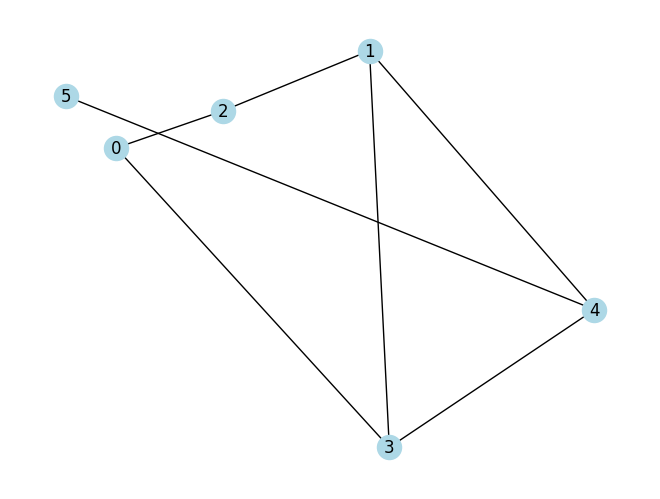

In [11]:
classical_config_list = []
classical_energy_list = []
classical_config, classical_energy = run_all2(6,4)

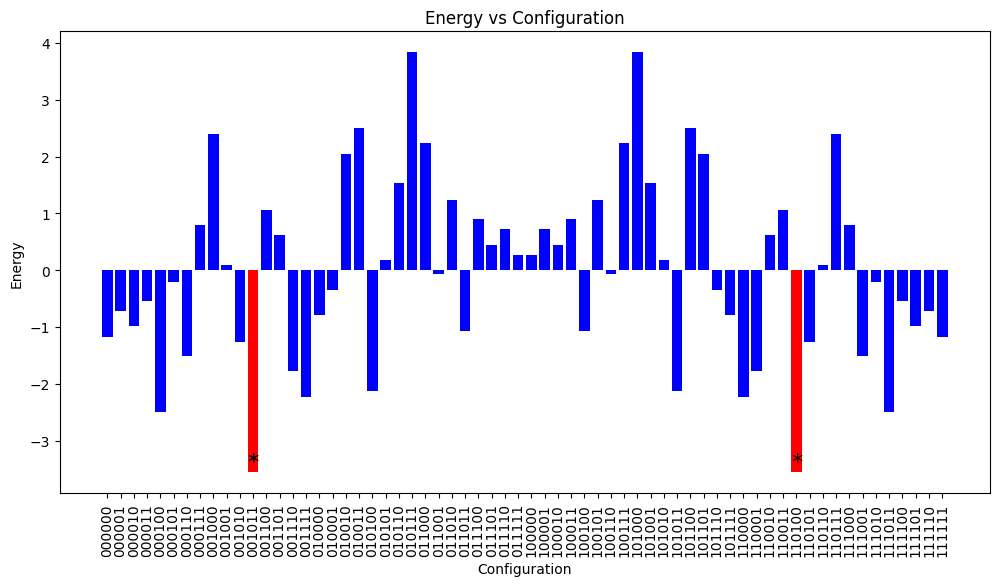

In [12]:
plot_configs_energy(classical_config_list, classical_energy_list)

# Example 3 (7 qubits)

In [16]:
def run_all3(n, reps):
    # Step 1: Define a random interaction graph
    graph, num_qubits = create_random_graph(n)
    
    # Step 2: Convert graph to Ising Hamiltonian
    hamiltonian = graph_to_hamiltonian(graph)
    print("Hamiltonian:\n", hamiltonian)
    
    # Step 3: Configure QAOA
    optimizer = COBYLA(maxiter=100)
    backend = Aer.get_backend('qasm_simulator')
    quantum_instance = QuantumInstance(backend, shots=2048)
    qaoa = QAOA(optimizer=optimizer, reps=reps, quantum_instance=quantum_instance)  # reps = number of QAOA layers
    backend = Aer.get_backend('qasm_simulator')


    # Run QAOA
    result = qaoa.compute_minimum_eigenvalue(hamiltonian)
    print("\n\nresult:", result)
    print("\n\nOptimal parameters:", result.optimal_parameters)

    # Step 4: Get the ground state configuration from QAOA
    counts = result.eigenstate
    if counts is not None:
        tot_prob = np.sum([counts[key]*np.conj(counts[key]) for key in counts])
        max_prob = np.max([counts[key]*np.conj(counts[key]) for key in counts])
        print("Total prob:",tot_prob)
        print("Max prob:",max_prob)
        for key in counts:
            if counts[key]*np.conj(counts[key]) == max_prob:
                print(counts[key],key[::-1])
                ground_state=key[::-1]
        print("\nQAOA ground state (bitstring):", ground_state,"\n")
    else:
        print("\nNo result from QAOA.\n")

    # Step 5: Verify with classical brute-force calculation
    classical_config, classical_energy = classical_ground_state(graph, num_qubits)
    print("\nClassical ground state (bitstring):", classical_config)
    print("\nClassical ground state energy:", classical_energy)
    return classical_config, classical_energy

Hamiltonian:
 0.4639878836228102 * ZIZIIII
- 0.9588310114083951 * IZZIIII
- 0.687962719115127 * ZIIZIII
+ 0.6648852816008435 * IZIZIII
- 0.13610996271576847 * IIZIZII
- 0.6006524356832805 * IIIIZZI
+ 0.2022300234864176 * ZIIIIIZ
- 0.7210122786959163 * IIZIIIZ
+ 0.18482913772408494 * IIIIZIZ


result: {   'aux_operator_eigenvalues': None,
    'cost_function_evals': 86,
    'eigenstate': {   '0000000': 0.14149039278339715,
                      '0000001': 0.06987712429686843,
                      '0000010': 0.0625,
                      '0000100': 0.07328774624724109,
                      '0000101': 0.03125,
                      '0000110': 0.11267347735824966,
                      '0000111': 0.04941058844013093,
                      '0001000': 0.04419417382415922,
                      '0001001': 0.04419417382415922,
                      '0001011': 0.02209708691207961,
                      '0001100': 0.02209708691207961,
                      '0001101': 0.02209708691207961,
      

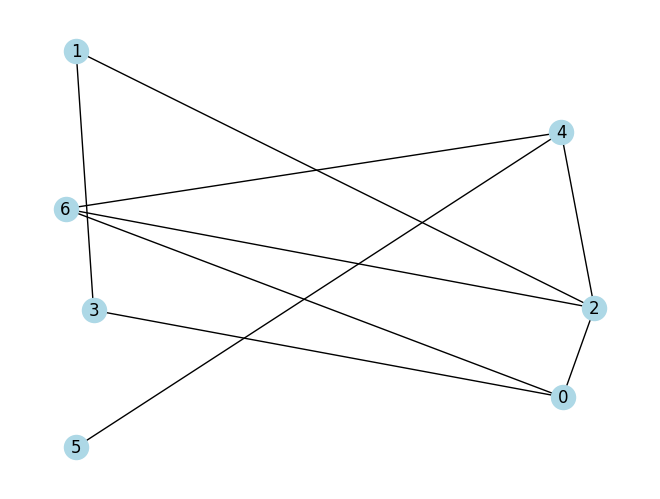

In [18]:
classical_config_list = []
classical_energy_list = []
classical_config, classical_energy = run_all2(7,4)

In [19]:
import matplotlib.pyplot as plt

def plot_configs_energy2(configs, energies):
    # Create bar graph
    fig, ax = plt.subplots(figsize=(18, 6))
    
    bars = ax.bar(configs, energies, color=['red' if config == classical_config else 'blue' for config in configs])
    bars2 = ax.bar(configs, energies, color=['red' if energy == classical_energy else 'blue' for energy in energies])

    # Add labels and title
    ax.set_xlabel('Configuration')
    ax.set_ylabel('Energy')
    ax.set_title('Energy vs Configuration')

    # Rotate x-axis labels and adjust font size
    ax.set_xticks(range(len(configs)))
    ax.set_xticklabels(configs, rotation=90, ha='center', fontsize=7)

    # Highlight lowest energy config with a marker
    for bar, config in zip(bars, configs):
        if config == classical_config:
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), '*', ha='center', va='bottom', fontsize=16, color='black')

    for bar, energy in zip(bars2, energies):
        if energy == classical_energy:
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), '*', ha='center', va='bottom', fontsize=16, color='black')

    # Show plot
    plt.show()

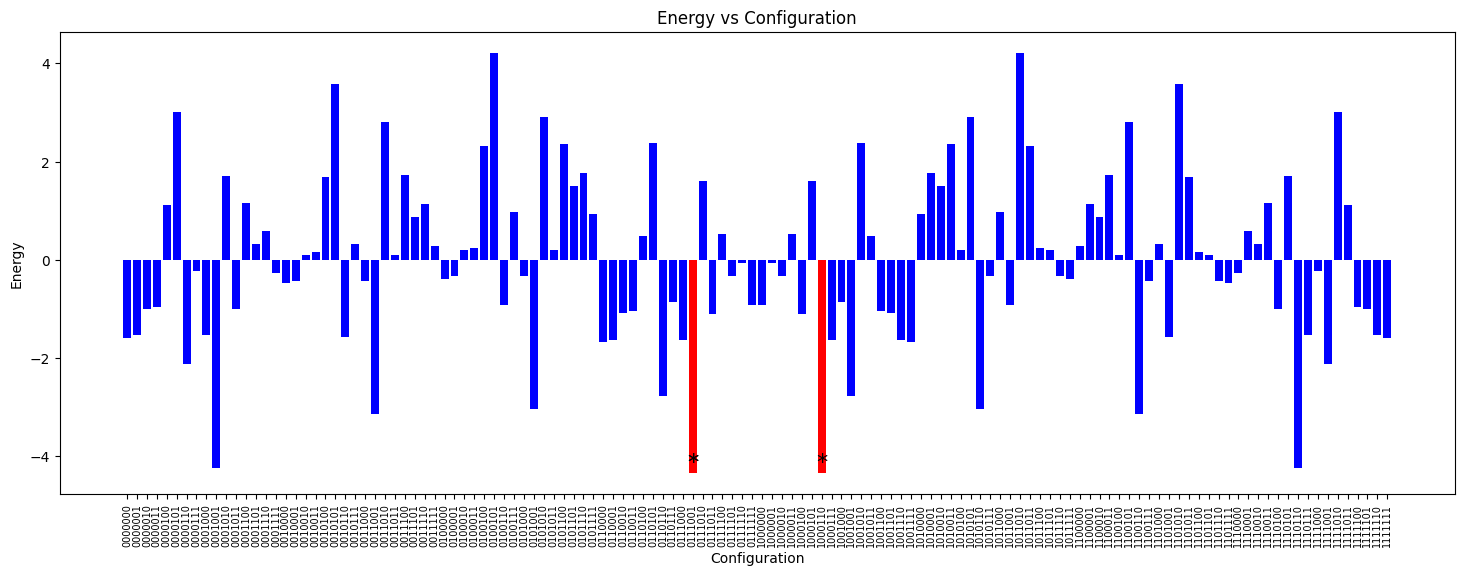

In [20]:
plot_configs_energy2(classical_config_list, classical_energy_list)

In [27]:
energy_state_dict = {}
for i in range(len(classical_config_list)):
    energy_state_dict[classical_config_list[i]]=classical_energy_list[i]

sorted_energy_state_dict = dict(sorted(energy_state_dict.items(), key=lambda item: item[1], reverse=False))
sorted_energy_state_dict

{'0111001': -4.348280808621107,
 '1000110': -4.348280808621107,
 '0001001': -4.250842458604473,
 '1110110': -4.250842458604473,
 '0011001': -3.1469759372545454,
 '1100110': -3.1469759372545454,
 '0101001': -3.0495375872379116,
 '1010110': -3.0495375872379116,
 '0110110': -2.7740161296879755,
 '1001001': -2.7740161296879755,
 '0000110': -2.1321379288082687,
 '1111001': -2.1321379288082687,
 '0110000': -1.6860744312009641,
 '1001111': -1.6860744312009641,
 '0110001': -1.6425848071891658,
 '1001110': -1.6425848071891658,
 '0111000': -1.6399195561723972,
 '1000111': -1.6399195561723972,
 '0000000': -1.5886360811843312,
 '1111111': -1.5886360811843312,
 '0010110': -1.5727112583214147,
 '1101001': -1.5727112583214147,
 '0000001': -1.5451464571725329,
 '1111110': -1.5451464571725329,
 '0001000': -1.5424812061557642,
 '1110111': -1.5424812061557642,
 '0111011': -1.1008482226026295,
 '1000100': -1.1008482226026295,
 '0110010': -1.0981829715858609,
 '1001101': -1.0981829715858609,
 '0110011': -1

# Example 4 (3 qubits)

Hamiltonian:
 0.4639878836228102 * ZIZ
- 0.687962719115127 * IZZ


result: {   'aux_operator_eigenvalues': None,
    'cost_function_evals': 100,
    'eigenstate': {   '000': 0.28641098093474,
                      '001': 0.11899645477912357,
                      '010': 0.04941058844013093,
                      '011': 0.6385255231782047,
                      '100': 0.6296700524878089,
                      '101': 0.05846339666834283,
                      '110': 0.125,
                      '111': 0.2795084971874737},
    'eigenvalue': (-0.9721284184949502+0j),
    'optimal_parameters': {   ParameterVectorElement(t[3]): -4.695768790978881,
                              ParameterVectorElement(t[6]): -3.9437592184869725,
                              ParameterVectorElement(t[7]): -3.1182031066915306,
                              ParameterVectorElement(t[0]): -1.1925466635283162,
                              ParameterVectorElement(t[2]): -4.338187954056035,
                           

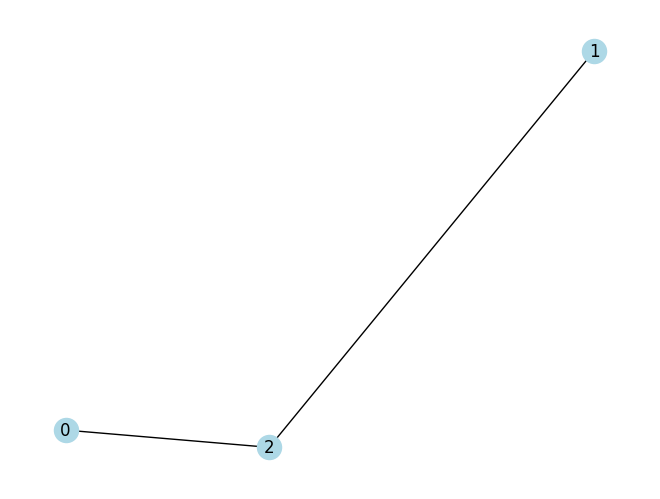

In [36]:
classical_config_list = []
classical_energy_list = []
classical_config, classical_energy = run_all3(3,4)

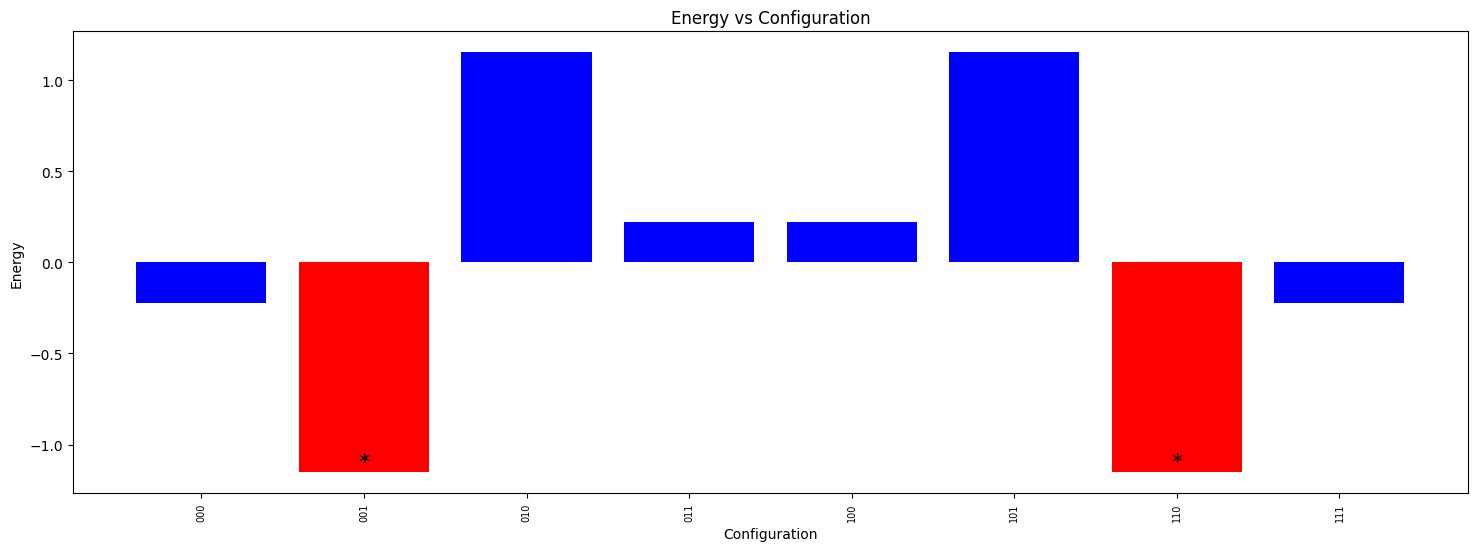

In [37]:
plot_configs_energy2(classical_config_list, classical_energy_list)

# By Hand Example

Consider a simple spin glass with three spins and random interactions:

Spin 1 and Spin 2 have a coupling strength of 0.5.
Spin 2 and Spin 3 have a coupling strength of -0.3.
Spin 1 and Spin 3 have a coupling strength of 0.8.
The Hamiltonian for this system is: $$H = 0.5 Z_1 Z_2 - 0.3 Z_2 Z_3 + 0.8 Z_1 Z_3$$

The energy distribution for different spin configurations will vary based on the random coupling strengths, leading, in general, to an asymmetrical distribution.

Random interactions:

- Spin 1 and Spin 2 have a coupling strength of 0.5.
- Spin 2 and Spin 3 have a coupling strength of -0.3.
- Spin 1 and Spin 3 have a coupling strength of 0.8.

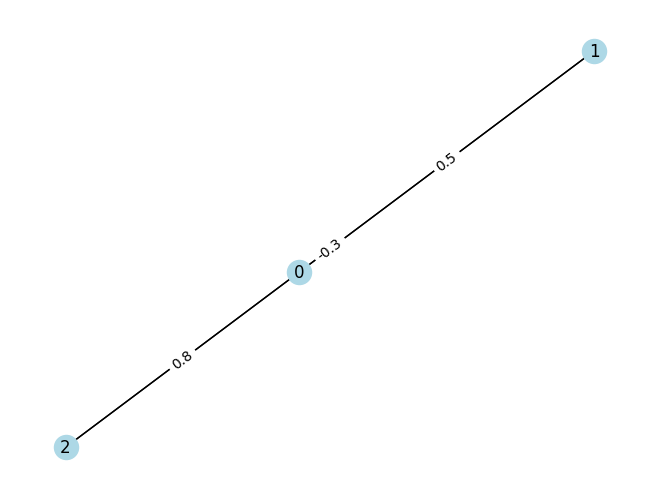

In [62]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

num_qubits = 3  # Small system for demonstration
graph = nx.Graph()
graph.add_nodes_from(range(num_qubits))
graph.add_edge(0, 1, weight=0.5)
graph.add_edge(1, 2, weight=-0.3)
graph.add_edge(0, 2, weight=0.8)

# Visualize the graph
pos = nx.spring_layout(graph)  # Position nodes using Fruchterman-Reingold force-directed algorithm
nx.draw(graph, pos, with_labels=True, node_color='lightblue')

# Draw edge labels (coupling strengths)
edge_labels = nx.get_edge_attributes(graph, 'weight')
nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)

plt.show()

In [54]:
from qiskit.opflow import PauliSumOp

# Step 1: Define the Hamiltonian terms
hamiltonian_terms = [
    ('ZZI', 0.5),  # 0.5 * Z_1 * Z_2 * I_3
    ('IZZ', -0.3), # -0.3 * I_1 * Z_2 * Z_3
    ('ZIZ', 0.8)   # 0.8 * Z_1 * I_2 * Z_3
]

# Create the Hamiltonian
hamiltonian = PauliSumOp.from_list(hamiltonian_terms)

# Print the Hamiltonian
print("Hamiltonian:\n", hamiltonian)

Hamiltonian:
 0.5 * ZZI
- 0.3 * IZZ
+ 0.8 * ZIZ


In [55]:
classical_config_list = []
classical_energy_list = []

# Step 2: Configure QAOA
optimizer = COBYLA(maxiter=100)
backend = Aer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=2048)
qaoa = QAOA(optimizer=optimizer, reps=4, quantum_instance=quantum_instance)  # reps = number of QAOA layers
backend = Aer.get_backend('qasm_simulator')


# Run QAOA
result = qaoa.compute_minimum_eigenvalue(hamiltonian)
print("\n\nresult:", result)
print("\n\nOptimal parameters:", result.optimal_parameters)

# Step 3: Get the ground state configuration from QAOA
counts = result.eigenstate
if counts is not None:
    tot_prob = np.sum([counts[key]*np.conj(counts[key]) for key in counts])
    max_prob = np.max([counts[key]*np.conj(counts[key]) for key in counts])
    print("Total prob:",tot_prob)
    print("Max prob:",max_prob)
    for key in counts:
        if counts[key]*np.conj(counts[key]) == max_prob:
            print(counts[key],key[::-1])
            ground_state=key[::-1]
    print("\nQAOA ground state (bitstring):", ground_state,"\n")
else:
    print("\nNo result from QAOA.\n")

# Step 4: Verify with classical brute-force calculation
classical_config, classical_energy = classical_ground_state(graph, num_qubits)
print("\nClassical ground state (bitstring):", classical_config)
print("\nClassical ground state energy:", classical_energy)



result: {   'aux_operator_eigenvalues': None,
    'cost_function_evals': 91,
    'eigenstate': {   '000': 0.19136638615493579,
                      '001': 0.14657549249448218,
                      '010': 0.10825317547305482,
                      '011': 0.65625,
                      '100': 0.6521448985846627,
                      '101': 0.1307281291459493,
                      '110': 0.14986973510352247,
                      '111': 0.18619336387207788},
    'eigenvalue': (-1.2645507812499999+0j),
    'optimal_parameters': {   ParameterVectorElement(t[2]): -2.648525766316039,
                              ParameterVectorElement(t[1]): 3.3158158231975516,
                              ParameterVectorElement(t[5]): 0.6025541865086546,
                              ParameterVectorElement(t[6]): -0.5454488035910722,
                              ParameterVectorElement(t[7]): -3.026686694140186,
                              ParameterVectorElement(t[3]): -2.89095523942005,
          

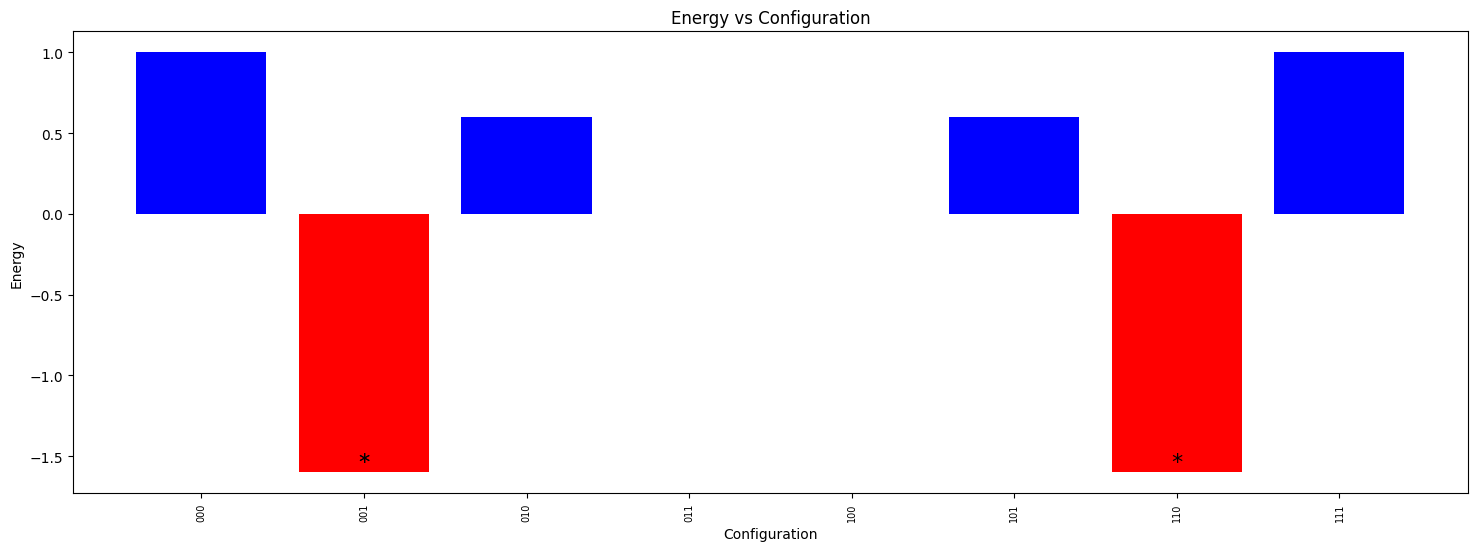

In [56]:
plot_configs_energy2(classical_config_list, classical_energy_list)

The energy distribution does appear to have some symmetry. Specifically, the energies for configurations 000 and 111 are the same, as are the energies for 001 and 110, and 010 and 101. This symmetry can occur in certain cases due to the specific structure of the interactions and the coupling strengths in the Hamiltonian.

In general, while spin glass systems are known for their complex and disordered energy landscapes, certain configurations and interaction patterns can lead to symmetrical energy distributions. This can happen when the interactions are balanced in such a way that flipping all spins (changing 0 to 1 and vice versa) results in the same energy.

The Hamiltonian: $$H = 0.5 Z_1 Z_2 - 0.3 Z_2 Z_3 + 0.8 Z_1 Z_3$$

has interactions that might lead to such symmetrical energy configurations. This is not always the case for all spin glass systems, but it can happen depending on the specific interactions and coupling strengths.